## Module

In [ ]:
import os, sys, urllib, warnings, errno, logging, time

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.model_selection import train_test_split

import torch.nn as nn

In [ ]:
sys.path.append('/content/drive/MyDrive/Research2021/IAF')

In [ ]:
from two_barycenter import *
from util import create_deep_tree_cd
from metrics import *

from ddl.base import (CompositeDestructor, DestructorMixin, create_inverse_transformer, 
                      BoundaryWarning, DataConversionWarning, IdentityDestructor)
from ddl.independent import IndependentDensity, IndependentDestructor, IndependentInverseCdf
from ddl.linear import LinearProjector
from ddl.univariate import HistogramUnivariateDensity, ScipyUnivariateDensity
from ddl.deep import DeepDestructor
from ddl.linear import LinearProjector, RandomOrthogonalEstimator, BestLinearReconstructionDestructor
from weakflow import *

warnings.simplefilter('ignore', BoundaryWarning) # Ignore boundary warnings from ddl
warnings.simplefilter('ignore', DataConversionWarning) # Ignore data conversion warnings from ddl

In [ ]:
sys.path.append('/content/drive/MyDrive/Research2021/IAF/SINF')

from SINF import *
from SIG import add_one_layer_inverse

In [ ]:
saving_dir = '/content/drive/MyDrive/Research2021/IAF/figures/two_toy'

In [ ]:
class SIG(nn.Module):

    # modified from https://github.com/biweidai/SINF

    def __init__(self, ndim, y):
        
        super().__init__()

        classes = unique_labels(y)
        SIT_dict = dict()
        for yy in classes:
            SIT_dict[yy] = SINF(ndim=ndim).requires_grad_(False).cuda() #SIT_dict[0] means generating 0 (1->0)
        self.SIT = SIT_dict
        self.classes = classes
        self.ndim = ndim

    def forward(self,X,y):
        Z = torch.zeros(X.shape)
        for yy in self.classes:
            X_temp = X[np.nonzero(y == yy)[0]]
            SIT_temp = self.SIT[int(1-yy)].cpu()
            zz,_ = SIT_temp(X_temp)
            Z[np.nonzero(y == yy)[0]] = zz
        return Z

    def inverse(self,X,y):
        Z = torch.zeros(X.shape)
        for yy in self.classes:
            X_temp = X[np.nonzero(y == yy)[0]]
            SIT_temp = self.SIT[int(1-yy)].cpu()
            zz,_ = SIT_temp.inverse(X_temp)
            Z[np.nonzero(y == yy)[0]] = zz
        return Z
    
    def add_newlayer(self,X, y, z_dict,k, nsample_A, nsample_spline, layer_type='regular', batchsize=None, sample_test= None, put_data_on_disk=False):
        # X: the real data that keeps unchanged
        # Z: the data that is moved to X
        for yy in self.classes:
            X_temp = X[np.nonzero(y == yy)[0]] # find the real samples of class yy
            z_temp  = z_dict[int(1-yy)] # find the samples from class 1-yy
            self.SIT[yy], z, z_test = add_one_layer_inverse(self.SIT[yy], X_temp, z_temp,K, nsample_A, nsample_spline, layer_type='regular', 
                                                               batchsize=batchsize, sample_test=sample_test, put_data_on_disk = put_data_on_disk)
            z_dict[int(1-yy)] = z
        return z_dict


## Moon

Train (2000, 2), Test: (1000, 2))


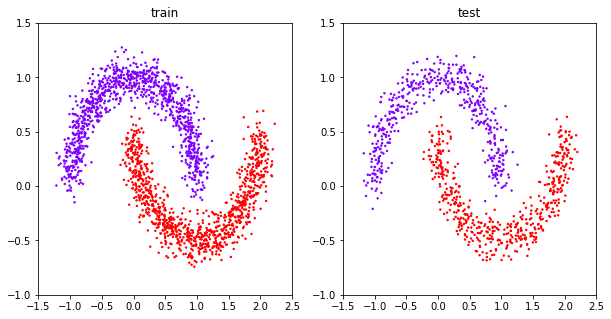

In [ ]:
# Make data
# rng = np.random.RandomState(0)
# X, y = make_moons(n_samples=3000, noise=0.1, random_state=rng)
# X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=2000, random_state=rng)
# torch.save(X_train,'/content/drive/My Drive/2020 Summer Research/Weakflow/experiment/Dataset/toy/moon_X_train.pt')
# torch.save(y_train,'/content/drive/My Drive/2020 Summer Research/Weakflow/experiment/Dataset/toy/moon_y_train.pt')
# torch.save(X_test,'/content/drive/My Drive/2020 Summer Research/Weakflow/experiment/Dataset/toy/moon_X_test.pt')
# torch.save(y_test,'/content/drive/My Drive/2020 Summer Research/Weakflow/experiment/Dataset/toy/moon_y_test.pt')

# Load data
X_train = torch.load('/content/drive/My Drive/2020 Summer Research/Weakflow/experiment/Dataset/toy/moon_X_train.pt')
y_train = torch.load('/content/drive/My Drive/2020 Summer Research/Weakflow/experiment/Dataset/toy/moon_y_train.pt')
X_test = torch.load('/content/drive/My Drive/2020 Summer Research/Weakflow/experiment/Dataset/toy/moon_X_test.pt')
y_test = torch.load('/content/drive/My Drive/2020 Summer Research/Weakflow/experiment/Dataset/toy/moon_y_test.pt')

print(f'Train {X_train.shape}, Test: {X_test.shape})')
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))
ax1.scatter(*X_train.T, c=y_train, s=2, cmap='rainbow')
ax1.set_title('train')
ax2.scatter(*X_test.T, c=y_test, s=2, cmap='rainbow')
ax2.set_title('test')
ax1.set_xlim(-1.5,2.5)
ax1.set_ylim(-1,1.5)
ax2.set_xlim(-1.5,2.5)
ax2.set_ylim(-1,1.5)
plt.show()
# X0 - purple
# X1 - red

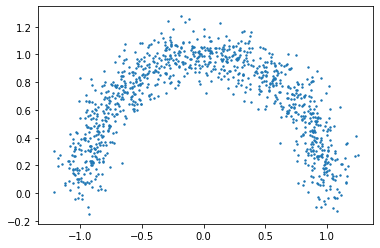

In [ ]:
plt.scatter(*X_train[y_train==0].T, s=2, cmap='rainbow')

### Training

In [ ]:
# rearrange the data
class_list = [0,1]
n_samples_list = [len(np.nonzero(y_train==l)[0]) for l in class_list]
n_samples = np.min(n_samples_list)

X0 = X_train[y_train==0,:]
X0 = X_train[np.nonzero(y_train==0)[0]]
X0 = X0[:n_samples]
y0 = y_train[np.nonzero(y_train==0)[0]]
y0 = y0[:n_samples]
X1 = X_train[np.nonzero(y_train==1)[0]]
X1 = X1[:n_samples]
y1 = y_train[np.nonzero(y_train==1)[0]]
y1 = y1[:n_samples]

X = np.concatenate((X0,X1))
y = np.concatenate((y0,y1))

In [ ]:
n_classes = len(class_list)
device = torch.device('cuda')

KDE = False
nsample_A = int(len(X)/n_classes)
nsample_spline = int(len(X)/n_classes)
#nsample = nsample_wT + nsample_spline 
batchsize = int(len(X)/n_classes)

K=2
cd_sig = SIG(2,y)

z = dict()
for yy in class_list:
    z_temp = torch.Tensor(X[np.nonzero(y == yy)[0]])
    z[yy]  = z_temp
# ,X, y, z_dict,k, nsample_A, nsample_spline, layer_type='regular', batchsize=None, sample_test= None, put_data_on_disk=False
n_layers = 15
for i in range(n_layers):
    z = cd_sig.add_newlayer(torch.Tensor(X), y, z, K, nsample_A, nsample_spline,'regular', batchsize=batchsize,put_data_on_disk = False)



/content/drive/MyDrive/Research2021/IAF/SINF/SINF.py:494: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:1940.)
  Q, R = torch.qr(ATi)


Fit A: Time: 0.11669135093688965 Wasserstein Distance: [1.2952638864517212, 0.3305201232433319]
Fit spline Time: 0.008593082427978516
Nlayer: 1 Time: 1.2650213241577148 regular

Fit A: Time: 0.018810510635375977 Wasserstein Distance: [1.2952662706375122, 0.33051154017448425]
Fit spline Time: 0.0045430660247802734
Nlayer: 1 Time: 0.027034759521484375 regular

Fit A: Time: 0.024576902389526367 Wasserstein Distance: [0.0663081482052803, 0.04211245849728584]
Fit spline Time: 0.0042285919189453125
Nlayer: 2 Time: 0.032117605209350586 regular

Fit A: Time: 0.04653120040893555 Wasserstein Distance: [0.05510851740837097, 0.0348777249455452]
Fit spline Time: 0.0031976699829101562
Nlayer: 2 Time: 0.05373024940490723 regular

Fit A: Time: 0.04379725456237793 Wasserstein Distance: [0.020734703168272972, 0.01345343142747879]
Fit spline Time: 0.0027313232421875
Nlayer: 3 Time: 0.05247092247009277 regular

Fit A: Time: 0.04626750946044922 Wasserstein Distance: [0.02383687160909176, 0.0173353143036365

### Evaluation

In [ ]:
n_samples_list = [len(np.nonzero(y_test==l)[0]) for l in class_list]
n_samples = np.min(n_samples_list)
X0 = X_test[np.nonzero(y_test==0)[0]]
X0 = X0[:n_samples]
y0 = y_test[np.nonzero(y_test==0)[0]]
y0 = y0[:n_samples]
X1 = X_test[np.nonzero(y_test==1)[0]]
X1 = X1[:n_samples]
y1 = y_test[np.nonzero(y_test==1)[0]]
y1 = y1[:n_samples]


X_test = np.concatenate((X0,X1))
y_test = np.concatenate((y0,y1))

In [ ]:
Xflip_sig = cd_sig.inverse(torch.Tensor(X_test),y_test)
Xflip_sig_inverse = cd_sig(torch.Tensor(X_test),1-y_test)

In [ ]:
Xflip01 = torch.cat((Xflip_sig[y_test==0],Xflip_sig_inverse[y_test==1])) # doublecheck - Xflip_sig[y_test==0] which uses the same direction as training generates 1, so it is 0->1
Xflip10 = torch.cat((Xflip_sig_inverse[y_test==0],Xflip_sig[y_test==1]))

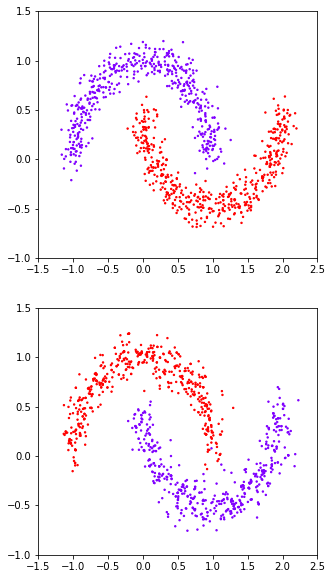

In [ ]:
fig, axs = plt.subplots(2,1,figsize=(5,10))
axs[0].scatter(*X_test.T, c=y_test, s=2, cmap='rainbow')
#axs[1].scatter(*Z_sig.T, c=y, s=2, cmap='rainbow')
axs[1].scatter(*Xflip01.T, c=y_test, s=2, cmap='rainbow')
axs[0].set_xlim(-1.5,2.5)
axs[0].set_ylim(-1,1.5)
#axs[1].set_xlim(-4,4)
#axs[1].set_ylim(-4,4)
axs[1].set_xlim(-1.5,2.5)
axs[1].set_ylim(-1,1.5)
#plt.savefig('/content/drive/My Drive/2020 Summer Research/Weakflow/experiment/figures/two_toy/moon_sig.png')
plt.show()

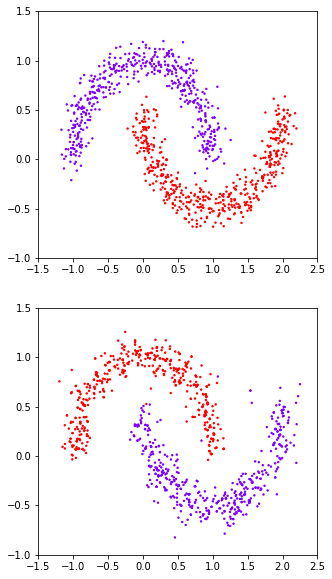

In [ ]:
fig, axs = plt.subplots(2,1,figsize=(5,10))
axs[0].scatter(*X_test.T, c=y_test, s=2, cmap='rainbow')
#axs[1].scatter(*Z_sig.T, c=y, s=2, cmap='rainbow')
axs[1].scatter(*Xflip10.T, c=y_test, s=2, cmap='rainbow')
axs[0].set_xlim(-1.5,2.5)
axs[0].set_ylim(-1,1.5)
#axs[1].set_xlim(-4,4)
#axs[1].set_ylim(-4,4)
axs[1].set_xlim(-1.5,2.5)
axs[1].set_ylim(-1,1.5)
#plt.savefig('/content/drive/My Drive/2020 Summer Research/Weakflow/experiment/figures/two_toy/moon_sig.png')
plt.show()

In [ ]:
n_samples_list_test = [len(np.nonzero(y_test==l)[0]) for l in class_list]
n_samples_test = np.min(n_samples_list_test)
wd_temp = wd_average(X_test, Xflip01, y_test, n_samples_test)
print(f'0->1: 2-wasserstein distance of SIG in the original space is {wd_temp}')
wd_temp = wd_average(X_test, Xflip10, y_test, n_samples_test)
print(f'1->0: 2-wasserstein distance of SIG in the original space is {wd_temp}')

0->1: 2-wasserstein distance of SIG in the original space is 0.002149765146896243
1->0: 2-wasserstein distance of SIG in the original space is 0.0030845089349895716


## Random

Train (2000, 2), Test: (1000, 2))


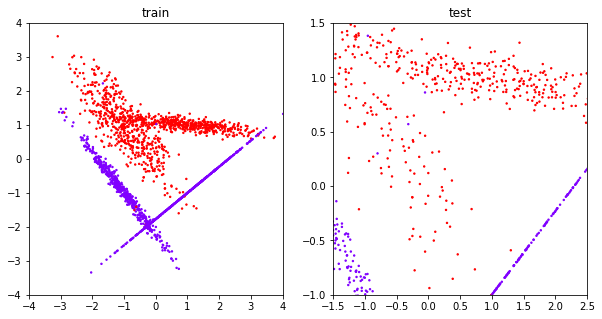

In [ ]:
# Make data
# rng = np.random.RandomState(0)
# X, y = make_moons(n_samples=3000, noise=0.1, random_state=rng)
# X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=2000, random_state=rng)
# torch.save(X_train,'/content/drive/My Drive/2020 Summer Research/Weakflow/experiment/Dataset/toy/moon_X_train.pt')
# torch.save(y_train,'/content/drive/My Drive/2020 Summer Research/Weakflow/experiment/Dataset/toy/moon_y_train.pt')
# torch.save(X_test,'/content/drive/My Drive/2020 Summer Research/Weakflow/experiment/Dataset/toy/moon_X_test.pt')
# torch.save(y_test,'/content/drive/My Drive/2020 Summer Research/Weakflow/experiment/Dataset/toy/moon_y_test.pt')

# Load data
X_train = torch.load('/content/drive/My Drive/2020 Summer Research/Weakflow/experiment/Dataset/toy/rand_X_train.pt')
y_train = torch.load('/content/drive/My Drive/2020 Summer Research/Weakflow/experiment/Dataset/toy/rand_y_train.pt')
X_test = torch.load('/content/drive/My Drive/2020 Summer Research/Weakflow/experiment/Dataset/toy/rand_X_test.pt')
y_test = torch.load('/content/drive/My Drive/2020 Summer Research/Weakflow/experiment/Dataset/toy/rand_y_test.pt')

print(f'Train {X_train.shape}, Test: {X_test.shape})')
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))
ax1.scatter(*X_train.T, c=y_train, s=2, cmap='rainbow')
ax1.set_title('train')
ax2.scatter(*X_test.T, c=y_test, s=2, cmap='rainbow')
ax2.set_title('test')
ax1.set_xlim(-4,4)
ax1.set_ylim(-4,4)
ax2.set_xlim(-1.5,2.5)
ax2.set_ylim(-1,1.5)
plt.show()

### Training

In [ ]:
# rearrange the data
class_list = [0,1]
n_samples_list = [len(np.nonzero(y_train==l)[0]) for l in class_list]
n_samples = np.min(n_samples_list)

X0 = X_train[y_train==0,:]
X0 = X_train[np.nonzero(y_train==0)[0]]
X0 = X0[:n_samples]
y0 = y_train[np.nonzero(y_train==0)[0]]
y0 = y0[:n_samples]
X1 = X_train[np.nonzero(y_train==1)[0]]
X1 = X1[:n_samples]
y1 = y_train[np.nonzero(y_train==1)[0]]
y1 = y1[:n_samples]

X = np.concatenate((X0,X1))
y = np.concatenate((y0,y1))

In [ ]:
n_classes = len(class_list)
device = torch.device('cuda')

KDE = False
nsample_A = int(len(X)/n_classes)
nsample_spline = int(len(X)/n_classes)
#nsample = nsample_wT + nsample_spline 
batchsize = int(len(X)/n_classes)

K=2
cd_sig = SIG(2,y)

z = dict()
for yy in class_list:
    z_temp = torch.Tensor(X[np.nonzero(y == yy)[0]])
    z[yy]  = z_temp
# ,X, y, z_dict,k, nsample_A, nsample_spline, layer_type='regular', batchsize=None, sample_test= None, put_data_on_disk=False
n_layers = 15
for i in range(n_layers):
    z = cd_sig.add_newlayer(torch.Tensor(X), y, z, K, nsample_A, nsample_spline,'regular', batchsize=batchsize,put_data_on_disk = False)



Fit A: Time: 0.02903437614440918 Wasserstein Distance: [1.5504568815231323, 1.2417963743209839]
Fit spline Time: 0.002835988998413086
Nlayer: 1 Time: 0.037189483642578125 regular

Fit A: Time: 0.016252994537353516 Wasserstein Distance: [1.550499677658081, 1.2417423725128174]
Fit spline Time: 0.0043544769287109375
Nlayer: 1 Time: 0.025261402130126953 regular

Fit A: Time: 0.051096200942993164 Wasserstein Distance: [0.111491359770298, 0.10440093278884888]
Fit spline Time: 0.003379344940185547
Nlayer: 2 Time: 0.05968761444091797 regular

Fit A: Time: 0.05123734474182129 Wasserstein Distance: [0.13970690965652466, 0.09204594045877457]
Fit spline Time: 0.002234935760498047
Nlayer: 2 Time: 0.06050586700439453 regular

Fit A: Time: 0.039560556411743164 Wasserstein Distance: [0.02932851016521454, 0.01796390861272812]
Fit spline Time: 0.0017638206481933594
Nlayer: 3 Time: 0.04903388023376465 regular

Fit A: Time: 0.03206610679626465 Wasserstein Distance: [0.12383019179105759, 0.0637633204460144

### Evaluation

In [ ]:
n_samples_list = [len(np.nonzero(y_test==l)[0]) for l in class_list]
n_samples = np.min(n_samples_list)
X0 = X_test[np.nonzero(y_test==0)[0]]
X0 = X0[:n_samples]
y0 = y_test[np.nonzero(y_test==0)[0]]
y0 = y0[:n_samples]
X1 = X_test[np.nonzero(y_test==1)[0]]
X1 = X1[:n_samples]
y1 = y_test[np.nonzero(y_test==1)[0]]
y1 = y1[:n_samples]


X_test = np.concatenate((X0,X1))
y_test = np.concatenate((y0,y1))

In [ ]:
Xflip_sig = cd_sig.inverse(torch.Tensor(X_test),y_test)
Xflip_sig_inverse = cd_sig(torch.Tensor(X_test),1-y_test)

In [ ]:
Xflip01 = torch.cat((Xflip_sig[y_test==0],Xflip_sig_inverse[y_test==1]))
Xflip10 = torch.cat((Xflip_sig_inverse[y_test==0],Xflip_sig[y_test==1]))

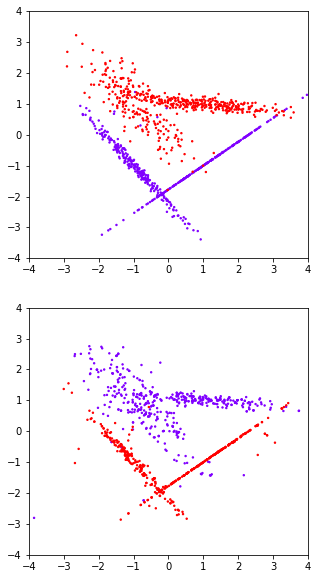

In [ ]:
fig, axs = plt.subplots(2,1,figsize=(5,10))
axs[0].scatter(*X_test.T, c=y_test, s=2, cmap='rainbow')
#axs[1].scatter(*Z_sig.T, c=y, s=2, cmap='rainbow')
axs[1].scatter(*Xflip01.T, c=y_test, s=2, cmap='rainbow')
axs[0].set_xlim(-4,4)
axs[0].set_ylim(-4,4)
#axs[1].set_xlim(-4,4)
#axs[1].set_ylim(-4,4)
axs[1].set_xlim(-4,4)
axs[1].set_ylim(-4,4)
#plt.savefig('/content/drive/My Drive/2020 Summer Research/Weakflow/experiment/figures/two_toy/moon_sig.png')
plt.show()

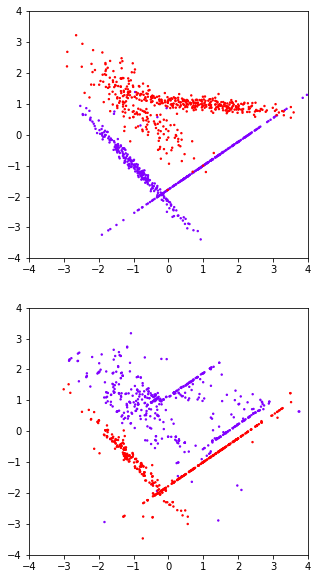

In [ ]:
fig, axs = plt.subplots(2,1,figsize=(5,10))
axs[0].scatter(*X_test.T, c=y_test, s=2, cmap='rainbow')
#axs[1].scatter(*Z_sig.T, c=y, s=2, cmap='rainbow')
axs[1].scatter(*Xflip10.T, c=y_test, s=2, cmap='rainbow')
axs[0].set_xlim(-4,4)
axs[0].set_ylim(-4,4)
#axs[1].set_xlim(-4,4)
#axs[1].set_ylim(-4,4)
axs[1].set_xlim(-4,4)
axs[1].set_ylim(-4,4)
#plt.savefig('/content/drive/My Drive/2020 Summer Research/Weakflow/experiment/figures/two_toy/moon_sig.png')
plt.show()

In [ ]:
n_samples_list_test = [len(np.nonzero(y_test==l)[0]) for l in class_list]
n_samples_test = np.min(n_samples_list_test)
wd_temp = wd_average(X_test, Xflip01, y_test, n_samples_test)
print(f'0->1: 2-wasserstein distance of SIG in the original space is {wd_temp}')
wd_temp = wd_average(X_test, Xflip10, y_test, n_samples_test)
print(f'1->0: 2-wasserstein distance of SIG in the original space is {wd_temp}')

0->1: 2-wasserstein distance of SIG in the original space is 0.034084148705005646
1->0: 2-wasserstein distance of SIG in the original space is 0.06002141907811165


## Circles

Train (2000, 2), Test: (1000, 2))


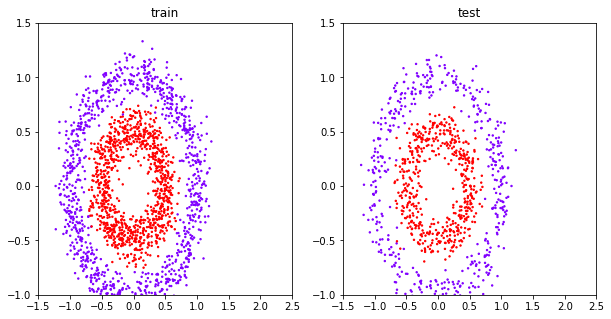

In [ ]:
# Make data
# rng = np.random.RandomState(0)
# X, y = make_moons(n_samples=3000, noise=0.1, random_state=rng)
# X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=2000, random_state=rng)
# torch.save(X_train,'/content/drive/My Drive/2020 Summer Research/Weakflow/experiment/Dataset/toy/moon_X_train.pt')
# torch.save(y_train,'/content/drive/My Drive/2020 Summer Research/Weakflow/experiment/Dataset/toy/moon_y_train.pt')
# torch.save(X_test,'/content/drive/My Drive/2020 Summer Research/Weakflow/experiment/Dataset/toy/moon_X_test.pt')
# torch.save(y_test,'/content/drive/My Drive/2020 Summer Research/Weakflow/experiment/Dataset/toy/moon_y_test.pt')

# Load data
X_train = torch.load('/content/drive/My Drive/2020 Summer Research/Weakflow/experiment/Dataset/toy/circle_X_train.pt')
y_train = torch.load('/content/drive/My Drive/2020 Summer Research/Weakflow/experiment/Dataset/toy/circle_y_train.pt')
X_test = torch.load('/content/drive/My Drive/2020 Summer Research/Weakflow/experiment/Dataset/toy/circle_X_test.pt')
y_test = torch.load('/content/drive/My Drive/2020 Summer Research/Weakflow/experiment/Dataset/toy/circle_y_test.pt')

print(f'Train {X_train.shape}, Test: {X_test.shape})')
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))
ax1.scatter(*X_train.T, c=y_train, s=2, cmap='rainbow')
ax1.set_title('train')
ax2.scatter(*X_test.T, c=y_test, s=2, cmap='rainbow')
ax2.set_title('test')
ax1.set_xlim(-1.5,2.5)
ax1.set_ylim(-1,1.5)
ax2.set_xlim(-1.5,2.5)
ax2.set_ylim(-1,1.5)
plt.show()

### Training

In [ ]:
# rearrange the data
class_list = [0,1]
n_samples_list = [len(np.nonzero(y_train==l)[0]) for l in class_list]
n_samples = np.min(n_samples_list)

X0 = X_train[y_train==0,:]
X0 = X_train[np.nonzero(y_train==0)[0]]
X0 = X0[:n_samples]
y0 = y_train[np.nonzero(y_train==0)[0]]
y0 = y0[:n_samples]
X1 = X_train[np.nonzero(y_train==1)[0]]
X1 = X1[:n_samples]
y1 = y_train[np.nonzero(y_train==1)[0]]
y1 = y1[:n_samples]

X = np.concatenate((X0,X1))
y = np.concatenate((y0,y1))

In [ ]:
n_classes = len(class_list)
device = torch.device('cuda')

KDE = False
nsample_A = int(len(X)/n_classes)
nsample_spline = int(len(X)/n_classes)
#nsample = nsample_wT + nsample_spline 
batchsize = int(len(X)/n_classes)

K=2
cd_sig = SIG(2,y)

z = dict()
for yy in class_list:
    z_temp = torch.Tensor(X[np.nonzero(y == yy)[0]])
    z[yy]  = z_temp
# ,X, y, z_dict,k, nsample_A, nsample_spline, layer_type='regular', batchsize=None, sample_test= None, put_data_on_disk=False
n_layers = 15
for i in range(n_layers):
    z = cd_sig.add_newlayer(torch.Tensor(X), y, z, K, nsample_A, nsample_spline,'regular', batchsize=batchsize,put_data_on_disk = False)



Fit A: Time: 0.0027501583099365234 Wasserstein Distance: [0.35602959990501404, 0.34371569752693176]
Fit spline Time: 0.004453897476196289
Nlayer: 1 Time: 0.014049053192138672 regular

Fit A: Time: 0.034296274185180664 Wasserstein Distance: [0.35580962896347046, 0.3439495861530304]
Fit spline Time: 0.0031354427337646484
Nlayer: 1 Time: 0.04326295852661133 regular

Fit A: Time: 0.05191302299499512 Wasserstein Distance: [0.05115809291601181, 0.04954235628247261]
Fit spline Time: 0.002764463424682617
Nlayer: 2 Time: 0.06013989448547363 regular

Fit A: Time: 0.08260011672973633 Wasserstein Distance: [0.02893042378127575, 0.028558576479554176]
Fit spline Time: 0.005129337310791016
Nlayer: 2 Time: 0.09232068061828613 regular

Fit A: Time: 0.025679588317871094 Wasserstein Distance: [0.017200270667672157, 0.016530603170394897]
Fit spline Time: 0.003899097442626953
Nlayer: 3 Time: 0.03403472900390625 regular

Fit A: Time: 0.05105447769165039 Wasserstein Distance: [0.01377933844923973, 0.01076132

### Evaluation

In [ ]:
n_samples_list = [len(np.nonzero(y_test==l)[0]) for l in class_list]
n_samples = np.min(n_samples_list)
X0 = X_test[np.nonzero(y_test==0)[0]]
X0 = X0[:n_samples]
y0 = y_test[np.nonzero(y_test==0)[0]]
y0 = y0[:n_samples]
X1 = X_test[np.nonzero(y_test==1)[0]]
X1 = X1[:n_samples]
y1 = y_test[np.nonzero(y_test==1)[0]]
y1 = y1[:n_samples]


X_test = np.concatenate((X0,X1))
y_test = np.concatenate((y0,y1))

In [ ]:
Xflip_sig = cd_sig.inverse(torch.Tensor(X_test),y_test)
Xflip_sig_inverse = cd_sig(torch.Tensor(X_test),1-y_test)

In [ ]:
Xflip01 = torch.cat((Xflip_sig[y_test==0],Xflip_sig_inverse[y_test==1]))
Xflip10 = torch.cat((Xflip_sig_inverse[y_test==0],Xflip_sig[y_test==1]))

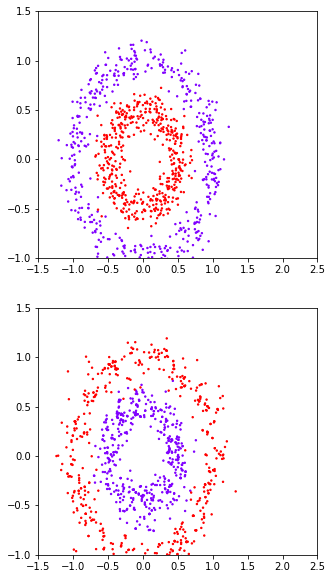

In [ ]:
fig, axs = plt.subplots(2,1,figsize=(5,10))
axs[0].scatter(*X_test.T, c=y_test, s=2, cmap='rainbow')
#axs[1].scatter(*Z_sig.T, c=y, s=2, cmap='rainbow')
axs[1].scatter(*Xflip01.T, c=y_test, s=2, cmap='rainbow')
axs[0].set_xlim(-1.5,2.5)
axs[0].set_ylim(-1,1.5)
#axs[1].set_xlim(-4,4)
#axs[1].set_ylim(-4,4)
axs[1].set_xlim(-1.5,2.5)
axs[1].set_ylim(-1,1.5)
#plt.savefig('/content/drive/My Drive/2020 Summer Research/Weakflow/experiment/figures/two_toy/moon_sig.png')
plt.show()

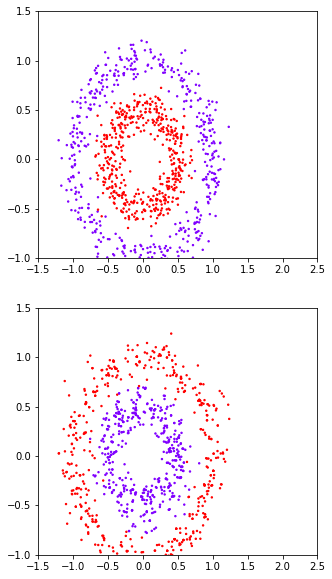

In [ ]:
fig, axs = plt.subplots(2,1,figsize=(5,10))
axs[0].scatter(*X_test.T, c=y_test, s=2, cmap='rainbow')
#axs[1].scatter(*Z_sig.T, c=y, s=2, cmap='rainbow')
axs[1].scatter(*Xflip10.T, c=y_test, s=2, cmap='rainbow')
axs[0].set_xlim(-1.5,2.5)
axs[0].set_ylim(-1,1.5)
#axs[1].set_xlim(-4,4)
#axs[1].set_ylim(-4,4)
axs[1].set_xlim(-1.5,2.5)
axs[1].set_ylim(-1,1.5)
#plt.savefig('/content/drive/My Drive/2020 Summer Research/Weakflow/experiment/figures/two_toy/moon_sig.png')
plt.show()

In [ ]:
n_samples_list_test = [len(np.nonzero(y_test==l)[0]) for l in class_list]
n_samples_test = np.min(n_samples_list_test)
wd_temp = wd_average(X_test, Xflip01, y_test, n_samples_test)
print(f'0->1: 2-wasserstein distance of SIG in the original space is {wd_temp}')
wd_temp = wd_average(X_test, Xflip10, y_test, n_samples_test)
print(f'1->0: 2-wasserstein distance of SIG in the original space is {wd_temp}')

0->1: 2-wasserstein distance of SIG in the original space is 0.002922405139543116
1->0: 2-wasserstein distance of SIG in the original space is 0.002660299534909427
